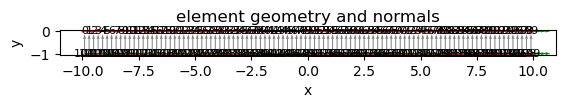

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import bemcs
import warnings

warnings.filterwarnings("ignore")

# Elastic parameter (shear modulus)
mu = 1.0
Lscale = 10
npts_layer = 101
bimaterial_depth = -1.0
mu_deep = 3.0
mu_shallow = 1.0
beta = (mu_deep - mu_shallow) / mu_shallow

els_source = bemcs.initialize_els()
els = bemcs.initialize_els()

# setup a fault geometry (source) - in this case it is a semi-infinite strike-slip fault
els_source.x1 = np.array([-0.0])
els_source.y1 = np.array([-1.0])
els_source.x2 = np.array([0])
els_source.y2 = np.array([-2.0])
bemcs.standardize_els_geometry(els_source, reorder=False)

# horizontal layers (at free surface + bimaterial)
xvals = np.linspace(-Lscale, Lscale, npts_layer)
els.x1 = np.hstack([xvals[0:-1], xvals[0:-1]])
els.x2 = np.hstack([xvals[1:], xvals[1:]])
els.y1 = np.hstack([xvals[0:-1] * 0, xvals[0:-1] * 0 + bimaterial_depth])
els.y2 = np.copy(els.y1)
bemcs.standardize_els_geometry(els, reorder=False)
topoindex = els.y1 == 0
bemcs.plot_els_geometry(els)

# Construct kernels and solve BEM problem

### Case of purely vertical stratification
In the case of a layered elastic material, $\alpha = 0$ and we can neglect $u_{,x_0}$ and $t$ for a flat free surface. This gives us,

$$
\begin{bmatrix} \phi_t \\ \phi_b \end{bmatrix} = 
\begin{bmatrix} 
-\beta\mathcal{G}_{,y}(\mathbf{x_b};\mathbf{x_t}) & 
I - \beta\mathcal{G}_{,y}(\mathbf{x_b};\mathbf{x_b})
\\
\mathcal{G}_{,y}(\mathbf{x_t};\mathbf{x_t}) & 
\mathcal{G}_{,y}(\mathbf{x_t};\mathbf{x_b})
\end{bmatrix}^{-1}
\begin{bmatrix}
\beta u_{,y_0}(\mathbf{x_b}) \\
-u_{,y_0}(\mathbf{x_t})
\end{bmatrix}
$$

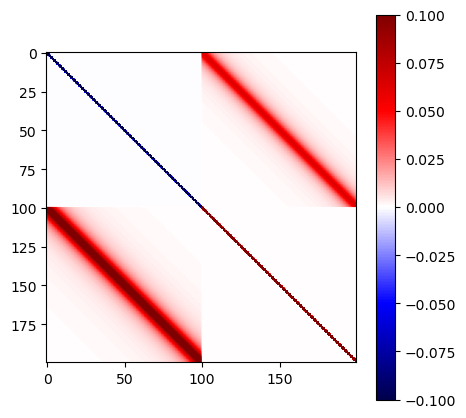

In [36]:
dr = -1e-9
xo = els.x_centers + dr * els.x_normals
yo = els.y_centers + dr * els.y_normals
K_sx, K_sy, _ = bemcs.get_displacement_stress_kernel_slip_antiplane(
    xo, yo, els_source, mu
)
quadcoefs = np.ones(3)

# compute grad(u) due to source at els
# (σ = 2με, ε = grad(u)/2 i.e., du/dx = σ/μ)
dudx0 = K_sx @ quadcoefs
dudy0 = K_sy @ quadcoefs

# compute els force kernels [Nobs x 2 x Nsources]
K_sx, K_sy, _ = bemcs.get_displacement_stress_kernel_force_antiplane(xo, yo, els, mu)
# construct constant kernels from linear kernels for this simple example
# (σ = 2με, ε = grad(u)/2 i.e., du/dx = σ/μ)
K_x = np.sum(K_sx, axis=1)
K_y = np.sum(K_sy, axis=1)

kernel = np.vstack(
    [
        np.hstack([K_y[topoindex][:, topoindex], K_y[topoindex][:, ~topoindex]]),
        np.hstack(
            [
                -beta * K_y[~topoindex][:, topoindex],
                np.eye(npts_layer - 1) - beta * K_y[~topoindex][:, ~topoindex],
            ]
        ),
    ]
)
plt.figure(figsize=(5, 5))
plt.imshow(kernel, cmap="seismic")
plt.colorbar()
plt.clim([-0.1, 0.1])
plt.show()

# Construct RHS for BEM and solve system of equations

Condition number of system: 3.507242923664196


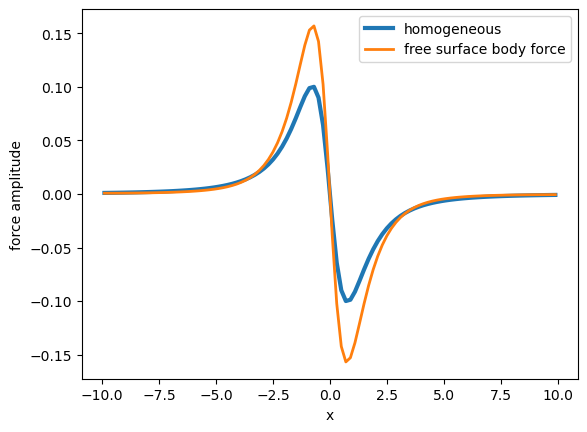

In [37]:
# construct vector for RHS (we only use dudy for the source term because of flat topo)
rhsvec = np.vstack(
    [-dudy0[topoindex].reshape(-1, 1), (beta * dudy0[~topoindex]).reshape(-1, 1)]
)
print("Condition number of system: " + str(np.linalg.cond(kernel)))
solvec = np.linalg.inv(kernel) @ rhsvec

# solve for purely topographic contribution
toposolvec = np.linalg.inv(K_y[topoindex][:, topoindex]) @ (
    -dudy0[topoindex].reshape(-1, 1)
)

plt.figure()
plt.plot(els.x_centers[topoindex], toposolvec, "-", linewidth=3, label="homogeneous")
plt.plot(
    els.x_centers[topoindex],
    solvec[topoindex],
    "-",
    linewidth=2,
    label="free surface body force",
)
# plt.plot(els.x_centers[~topoindex], solvec[~topoindex], "-", label="body force")
plt.legend()
plt.ylabel("force amplitude")
plt.xlabel("x")
plt.show()

# Plot results

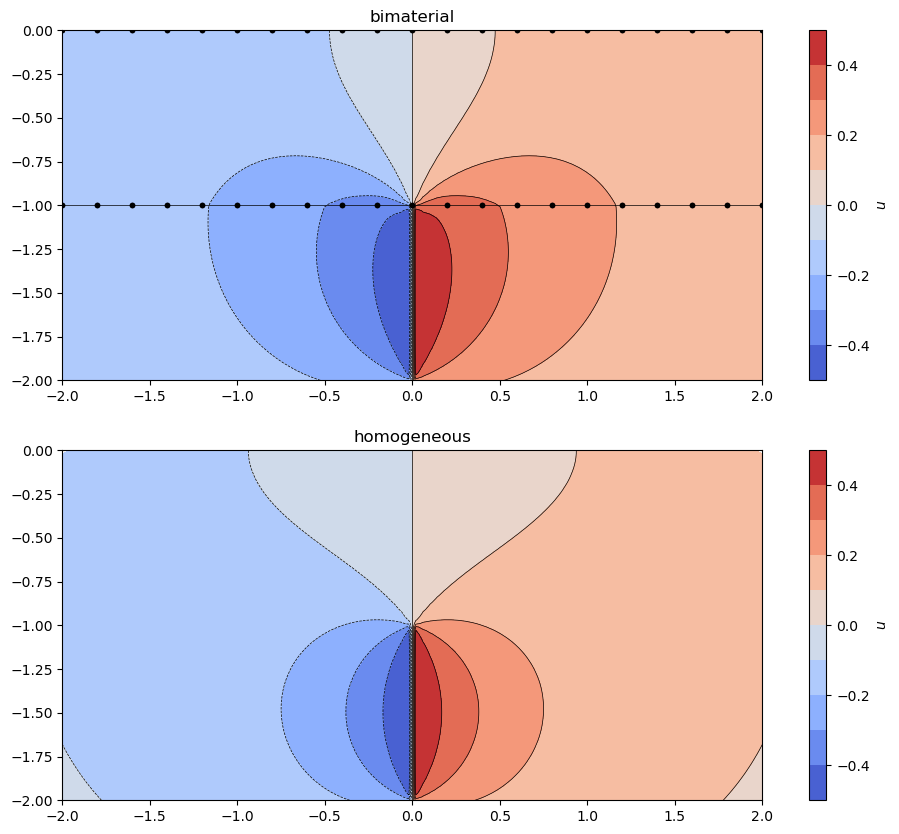

In [38]:
# plot resulting displacement field
nx_obs = 100
ny_obs = 100
x_obs = np.linspace(-2, 2, nx_obs)
y_obs = np.linspace(-2, 0, ny_obs)
x_obs, y_obs = np.meshgrid(x_obs, y_obs)
xo = x_obs.flatten().reshape(-1, 1)
yo = y_obs.flatten().reshape(-1, 1)

_, _, K_u = bemcs.get_displacement_stress_kernel_force_antiplane(xo, yo, els, mu)
Ku = np.sum(K_u, axis=1)

_, _, Ku0 = bemcs.get_displacement_stress_kernel_slip_antiplane(xo, yo, els_source, mu)
# compute displacements
u = Ku @ solvec + Ku0 @ quadcoefs.reshape(-1, 1)
u_topo = Ku[:, topoindex] @ toposolvec + Ku0 @ quadcoefs.reshape(-1, 1)

plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
toplot = u.reshape(ny_obs, nx_obs)
maxval = 0.5
minval = -maxval
levels = np.linspace(minval, maxval, 11)
plt.contourf(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    cmap="coolwarm",
    vmin=minval,
    vmax=maxval,
    levels=levels,
)
for i in range(len(els.x1)):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k.-", linewidth=0.5)
plt.colorbar(label="$u$")
plt.contour(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    colors="k",
    levels=levels,
    linewidths=0.5,
)
plt.xlim([-2, 2])
plt.ylim([-2, 0])
plt.clim([minval, maxval])
plt.title("bimaterial")
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(2, 1, 2)
toplot = u_topo.reshape(ny_obs, nx_obs)
plt.contourf(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    cmap="coolwarm",
    vmin=minval,
    vmax=maxval,
    levels=levels,
)
plt.colorbar(label="$u$")
plt.contour(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    colors="k",
    levels=levels,
    linewidths=0.5,
)
plt.xlim([-2, 2])
plt.ylim([-2, 0])
plt.clim([minval, maxval])
plt.title("homogeneous")
plt.gca().set_aspect("equal", adjustable="box")
plt.show()